# Technika regulacji - Projekt 2

**Autorzy:** Iwo Chwiszczuk 280043, Szymon Flis 280153

📅 **Data:** 27 kwietnia 2025 

## Przygotowanie potrzebnych bibliotek i narzędzi oraz wyliczenie stałych A, B i C

In [3]:
import sympy as sp
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from scipy.optimize import curve_fit
sp.init_printing()

t, s, K_p, K_i = sp.symbols('t, s, K_p, K_i')


A, B = 3, 3
C = A + B

## Zadanie 1

### Dany jest obiekt inercyjny o transmitancji:
$$
G_1(s)=\frac{A}{Bs+1} \quad dla \quad A=B=3
$$

In [4]:
g = ctrl.TransferFunction([A], [B, 1])

### Charakterystyka amplitudowo-fazowa (Nyquista) wygenerowana dla transmitancji $G_1(s)$ automatycznie funkcją "nyquist_plot":

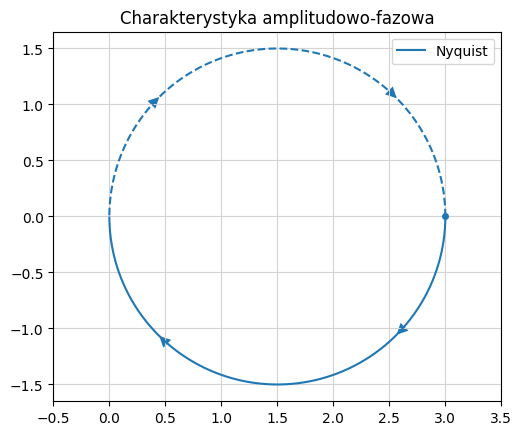

In [13]:
fig, ax = plt.subplots()

ctrl.nyquist_plot(g, ax=ax, label='Nyquist')

ax.set_title('Charakterystyka amplitudowo-fazowa')
ax.set_aspect('equal')
ax.set_xlim(-0.5, 3.5)
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

### Wyznaczanie charakterystyki amplitudowo-fazowej "ręcznie" poprzez przepuszczenie sygnału $u(t)=sin(\omega _0 t)$ przez obiekt o transmitancji $G_1(s)$:

Wyjście $y(t)$ obiektu jest aproksymowane funkcją $Asin(\omega _0 t + \phi)$ aby uzyskać wartości amplitudy i przesunięcia fazowego ($A, \phi$). Po przepuszczeniu $u(t)$ przez obiekt, $y(t)$ stablilizuje się dopiero po kilku okresach sygnału, dlatego przed aproksymacją początkowa część sygnału jest odcinana.

A: 0.33058875341011185, phi: -1.4590617000692612


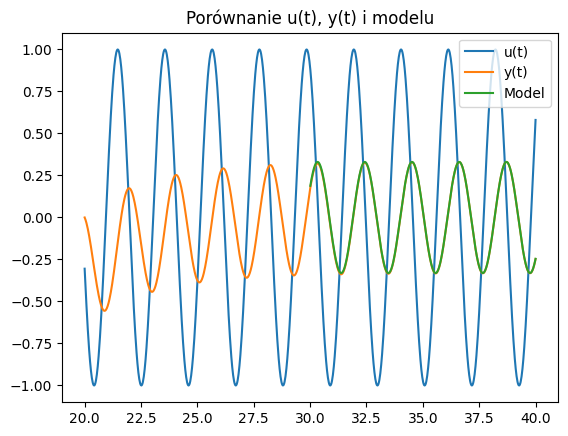

In [30]:
omega_0 = 3

t_in = np.linspace(20, 40, 1000)
u_in = np.sin(omega_0 * t_in)
t_out, y_out = ctrl.forced_response(g, T=t_in, U=u_in)

t_stablized = t_out[int(0.5*len(t_in)):]
y_stablized = y_out[int(0.5*len(t_in)):]

def sin_model(t, A, phi):
    return A * np.sin(omega_0 * t + phi)

params, _ = curve_fit(sin_model, t_stablized, y_stablized, p0=[1, 0])
A, phi = params
print(f"A: {A}, phi: {phi}")
y_model = sin_model(t_stablized, A, phi)

fig2, ax2 = plt.subplots()
ax2.set_title('Porównanie u(t), y(t) i modelu')
ax2.plot(t_in, u_in, label="u(t)")
ax2.plot(t_out, y_out, label="y(t)")
ax2.plot(t_stablized, y_model, label="Model")
ax2.legend()
plt.show()

Symulacja taka została powtórzona dla różnych $\omega _0$, a wartości $A$ i $\phi$ naszkicowane zostały na wykresie o współrzędnych biegunowych. Otrzymano w ten sposób charakterystykę amplitudowo-fazową wyznaczoną "ręcznie" (faktycznie otrzymano jedynie dolną połowę wykresu - górna jest odbiciem dolnej względem osi X). Na ten sam wykres naniesiono również charakterystykę otrzymaną funkcją "nyquist_plot".

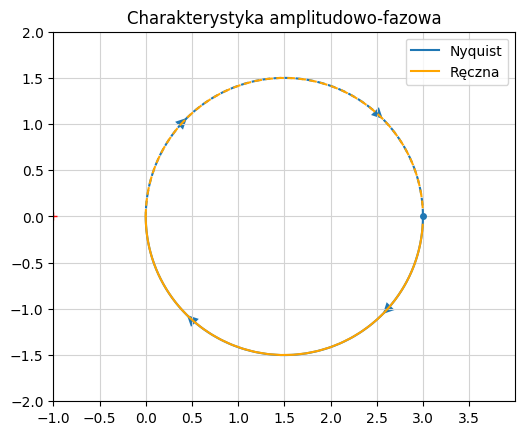

In [62]:
fig3, ax3 = plt.subplots()
ax3.set_title('Charakterystyka amplitudowo-fazowa')
x_points = []
y_points = []

t_in = np.linspace(0, 150, 4000)

for omega in np.logspace(-2, 2, 100):
    u_in = np.sin(omega * t_in)
    t_out, y_out = ctrl.forced_response(g, T=t_in, U=u_in)
    (A, phi), _ = curve_fit(lambda t,A,phi : A*np.sin(omega*t+phi), t_out[int(0.5*len(t_in)):], y_out[int(0.5*len(t_in)):], p0=[1, 0])
    x_points.append(A*np.cos(phi))
    y_points.append(A*np.sin(phi))

x_points, y_points = np.array(x_points), np.array(y_points)

ctrl.nyquist_plot(g, ax=ax3, label='Nyquist')
ax3.plot(x_points, y_points, color='orange', label='Ręczna')
ax3.plot(x_points, -y_points, linestyle='--', color='orange')
ax3.set_xlim(-1, 4)
ax3.set_xticks(np.arange(-1, 4, 0.5))
ax3.set_ylim(-2, 2)
ax3.set_aspect('equal')
ax3.legend(loc='upper right')
ax3.set_xlabel('')
ax3.set_ylabel('')
# ax3.grid()
plt.show()


### Interpretacja wyników:
- Charakterystyka tego układu ma postać okręgu o promieniu 1.5 i środku w punkcie (1.5, 0). Zgadza się to z teorią dla układu pierwszego rzędu.
- Brak obecności charakterystyki w punkcie (-1, 0) oznacza że układ jest stabliny.
- Charakterystyki otrzymane "ręcznie" i automatycznie wygenerowy wykres Nyquista pokrywają się. Przy założeniu poprawności automatycznej generacji charakterysytyki oznacza to poprawność podejścia "ręcznego".


## Zadanie 2

In [223]:
G2_s = C/((s+2)*(s+3)*(s-1))
display(Markdown(f"$$G_2(s) = {sp.latex(G2_s)}$$"))

$$G_2(s) = \frac{6}{\left(s - 1\right) \left(s + 2\right) \left(s + 3\right)}$$

### Wyznaczanie teorytycznego zakresu stabilności układu regulacji z regulatorem P oraz PI

#### Regulator P
Funkcja wyznaczająca zakres stabilności układu regulacji z regulatorem P

In [224]:
def hurwitz_matrix(poly_coeffs):
    n = len(poly_coeffs) - 1
    H = sp.zeros(n, n)

    for col in range(n):
        row = 2*col + 1
        coeff_index = 0
        while(coeff_index <= n and row >= 0):
            if(row < n):
                H[row, col] = poly_coeffs[coeff_index]
            coeff_index += 1
            row -= 1
    return H

def check_stability_P(G_s, K_p):
    char_eq = sp.Eq(1 + K_p * G_s, 0).simplify()
    char_poly = sp.fraction(char_eq.lhs)[0].expand()

    coeffs = sp.Poly(char_poly, s).all_coeffs()
    H = hurwitz_matrix(coeffs)

    conditions = [sp.simplify(coeff > 0) for coeff in coeffs]
    for i in range(1, H.rows + 1):
        minor = H[:i, :i].det()
        conditions.append(sp.simplify(minor > 0))
    
    return sp.solve(conditions, K_p, domain=sp.Reals), char_poly, H


sol_P_G2_s = check_stability_P(G2_s, K_p)
display(Markdown(f"**Wielomian charakterystyczny układu:** ${sp.latex(sol_P_G2_s[1])}$"))
display(Markdown(f"**Macierz Hurwitza:** ${sp.latex(sol_P_G2_s[2])}$"))
display(Markdown(f"**Zakres stabilności układu:** ${sp.latex(sol_P_G2_s[0])}$"))

**Wielomian charakterystyczny układu:** $6 K_{p} + s^{3} + 4 s^{2} + s - 6$

**Macierz Hurwitza:** $\left[\begin{matrix}4 & 6 K_{p} - 6 & 0\\1 & 1 & 0\\0 & 4 & 6 K_{p} - 6\end{matrix}\right]$

**Zakres stabilności układu:** $1 < K_{p} \wedge K_{p} < \frac{5}{3}$

#### Regulator PI
Funkcja wyznaczająca warunki stabilności układu regulacji z regulatorem PI

In [225]:
def check_stability_PI(G_s, K_p, K_i):
    char_eq = sp.Eq(1 + (K_p + K_i / s) * G_s, 0).simplify()
    char_poly = sp.fraction(char_eq.lhs)[0].expand()
    
    coeffs = sp.Poly(char_poly, s).all_coeffs()
    H = hurwitz_matrix(coeffs)

    conditions = [sp.simplify(coeff > 0) for coeff in coeffs]
    for i in range(1, H.rows + 1):
        minor = H[:i, :i].det()
        conditions.append(sp.simplify(minor > 0))

    return conditions, char_poly, H


sol_PI_G2_s = check_stability_PI(G2_s, K_p, K_i)
display(Markdown(f"**Wielomian charakterystyczny układu:** ${sp.latex(sol_PI_G2_s[1])}$"))
display(Markdown(f"**Macierz Hurwitza:** ${sp.latex(sol_PI_G2_s[2])}$"))

i = 1
display(Markdown("**Warunki stabilności:**"))
conditions = [cond for cond in sol_PI_G2_s[0] if(cond != True)]
for cond in conditions:
    display(Markdown(f"**Warunek {i}:** ${sp.latex(cond)}$"))
    i += 1

**Wielomian charakterystyczny układu:** $6 K_{i} + 6 K_{p} s + s^{4} + 4 s^{3} + s^{2} - 6 s$

**Macierz Hurwitza:** $\left[\begin{matrix}4 & 6 K_{p} - 6 & 0 & 0\\1 & 1 & 6 K_{i} & 0\\0 & 4 & 6 K_{p} - 6 & 0\\0 & 1 & 1 & 6 K_{i}\end{matrix}\right]$

**Warunki stabilności:**

**Warunek 1:** $K_{p} > 1$

**Warunek 2:** $K_{i} > 0$

**Warunek 3:** $K_{p} < \frac{5}{3}$

**Warunek 4:** $96 K_{i} + 36 K_{p}^{2} - 96 K_{p} + 60 < 0$

**Warunek 5:** $72 K_{i} \left(- 8 K_{i} - 3 K_{p}^{2} + 8 K_{p} - 5\right) > 0$

##### Analityczne wyznaczenie zakresu stabilności układu
Z Warunku 4.:
$$K_i < -\frac{3}{8}{K_{p}}^2 + K_p - \frac{5}{8}$$

Z Warunku 5.:
- z Warunku 2. wiemy, że:
$$K_i > 0$$
- więc:
$$-8K_i - 3{K_{p}}^2 + 8K_p - 5 > 0 \implies K_i < -\frac{3}{8}{K_{p}}^2 + K_p - \frac{5}{8}$$

Podsumowując:
$$1 < K_p < \frac{5}{3}$$
$$0 < K_i < -\frac{3}{8}{K_{p}}^2 + K_p - \frac{5}{8}$$

##### Obszar stabilności

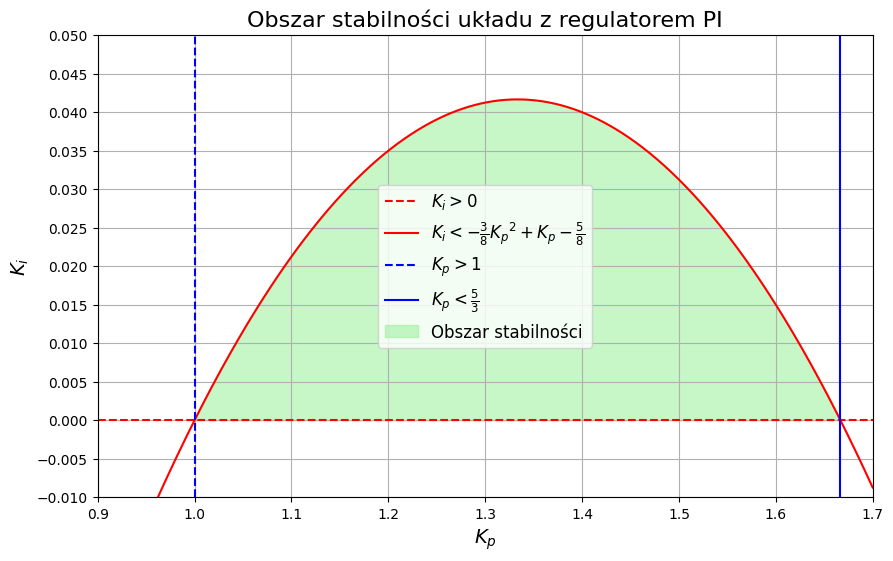

In [226]:
K_p_values = np.linspace(0.9, 1.7, 1000)
K_i_values = np.linspace(-0.01, 0.05, 1000)

plt.figure(figsize=(10, 6))
plt.axhline(0, color='r', linestyle='--', label=r'$K_i > 0$')
plt.plot(K_p_values, -3/8*K_p_values**2 + K_p_values - 5/8, 'r', label=r'$K_i < -\frac{3}{8}{K_p}^2 + K_p - \frac{5}{8}$')

plt.axvline(1, color='b', linestyle='--', label=r'$K_p > 1$')
plt.axvline(5/3, color='b', label=r'$K_p < \frac{5}{3}$')

plt.fill_between(K_p_values[(K_p_values > 1) & (K_p_values < 5/3)], 0, -3/8*K_p_values[(K_p_values > 1) & (K_p_values < 5/3)]**2 + K_p_values[(K_p_values > 1) & (K_p_values < 5/3)] - 5/8, 
                color='lightgreen', alpha=0.5, label='Obszar stabilności')

plt.xticks(np.arange(0.8, 1.8, step=0.1))
plt.yticks(np.arange(-0.01, 0.055, step=0.005))
plt.xlabel(r'$K_p$', fontsize=14)
plt.ylabel(r'$K_i$', fontsize=14)
plt.title('Obszar stabilności układu z regulatorem PI', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xlim(0.9, 1.7)
plt.ylim(-0.01, 0.05)
plt.show()

### Symulacja różnych konfiguracji parametrów regulatora

#### Regulator P

$K_p \not\in (1, \frac53) \implies$ **układ niestabilny**

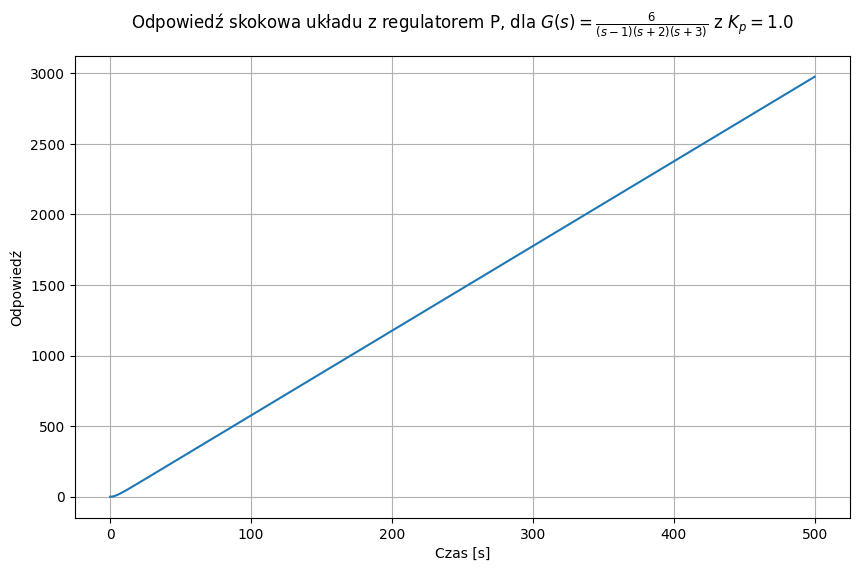

$K_p \not\in (1, \frac53) \implies$ **układ niestabilny**

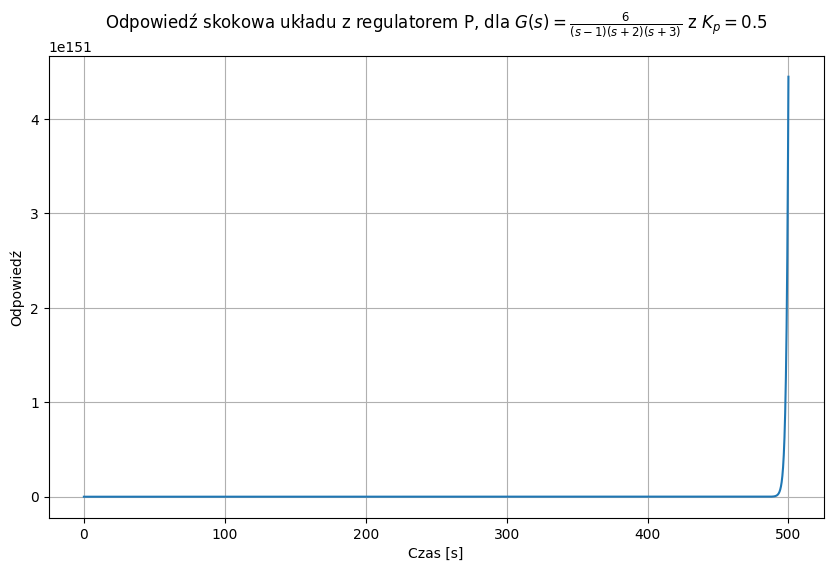

$K_p \in (1, \frac53) \implies$ **układ stabilny**

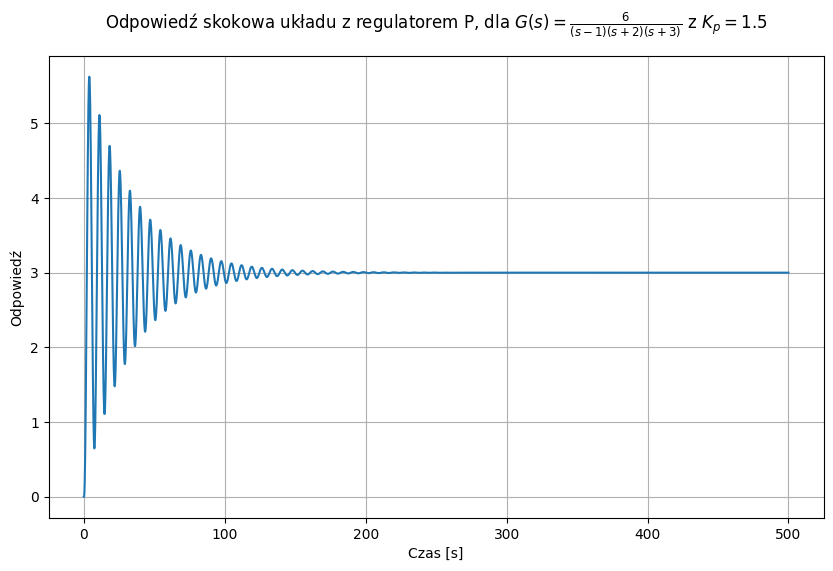

$K_p \not\in (1, \frac53) \implies$ **układ niestabilny**

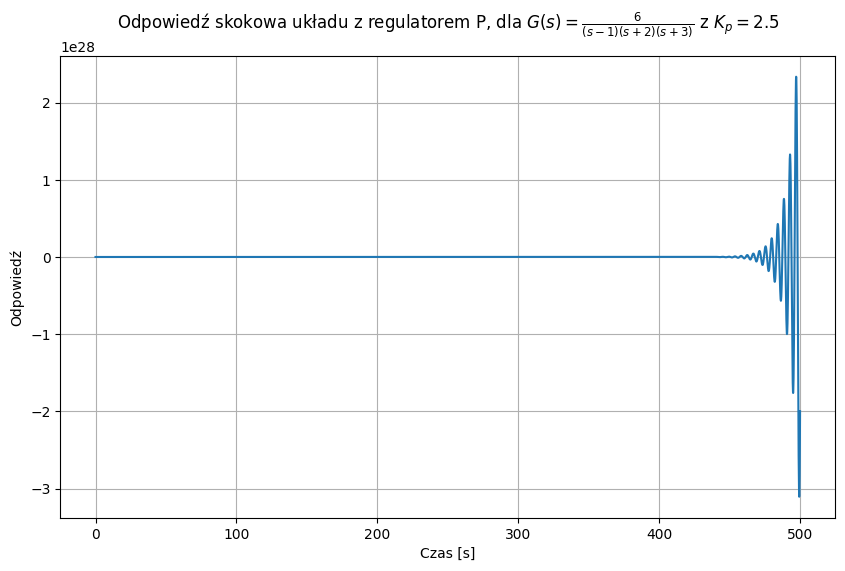

In [229]:
def P_regulator_step_resp(G, K_p):
    L_s, M_s = sp.fraction(G)
    num_coeffs = [float(c) for c in sp.Poly(L_s, s).all_coeffs()]
    den_coeffs = [float(c) for c in sp.Poly(M_s, s).all_coeffs()]
    G_tf = ctrl.TransferFunction(num_coeffs, den_coeffs)

    plt.figure(figsize=(10, 6))

    # Transmitancja regulatora P - K_p
    C = ctrl.TransferFunction([K_p], [1])
    
    # Ujemne sprzężenie zwrotne
    T = ctrl.feedback(C * G_tf, 1)
    
    # Odpowiedź skokowa układu
    t, y = ctrl.step_response(T, T=500)
    
    plt.plot(t, y)

    plt.title(fr'Odpowiedź skokowa układu z regulatorem P, dla $G(s) = {sp.latex(G)}$ z $K_p = {K_p}$', pad=20)
    plt.xlabel('Czas [s]')
    plt.ylabel('Odpowiedź')
    plt.grid(True)
    plt.show()


display(Markdown(fr'$K_p \not\in (1, \frac{5}{3}) \implies$ **układ niestabilny**'))
P_regulator_step_resp(G2_s, 1.0)

display(Markdown(fr'$K_p \not\in (1, \frac{5}{3}) \implies$ **układ niestabilny**'))
P_regulator_step_resp(G2_s, 0.5)

display(Markdown(fr'$K_p \in (1, \frac{5}{3}) \implies$ **układ stabilny**'))
P_regulator_step_resp(G2_s, 1.5)

display(Markdown(fr'$K_p \not\in (1, \frac{5}{3}) \implies$ **układ niestabilny**'))
P_regulator_step_resp(G2_s, 2.5)

#### Regulator PI

$K_p \not\in (1, \frac53)$, $K_i \not\in (0, -\frac38K_p^2 + K_p - \frac58) \implies$ **układ niestabilny**

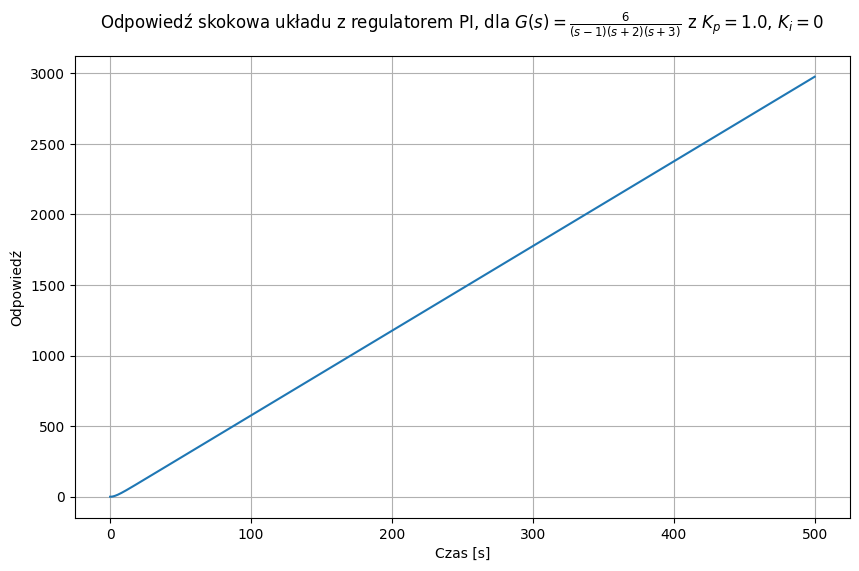

$K_p \not\in (1, \frac53)$, $K_i \not\in (0, -\frac38K_p^2 + K_p - \frac58) \implies$ **układ niestabilny**

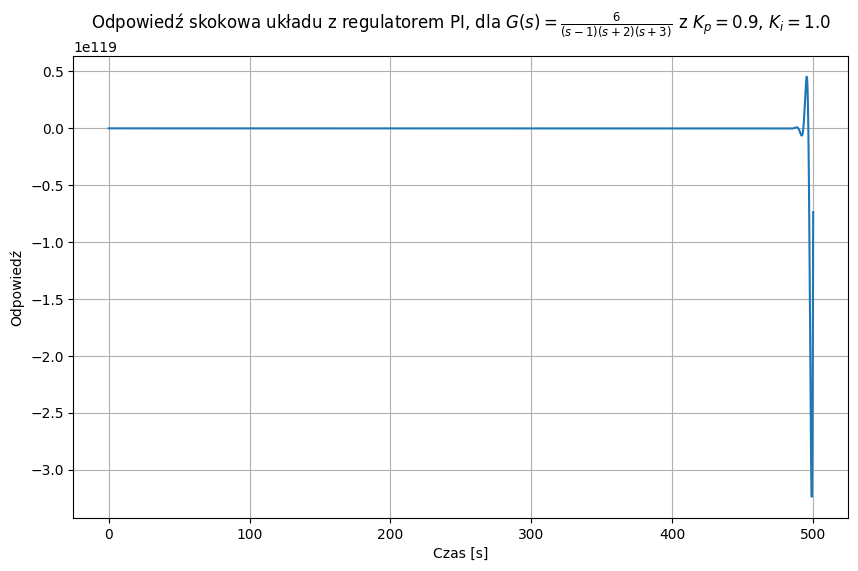

$K_p \in (1, \frac53)$, $K_i \not\in (0, -\frac38K_p^2 + K_p - \frac58) \implies$ **układ niestabilny**

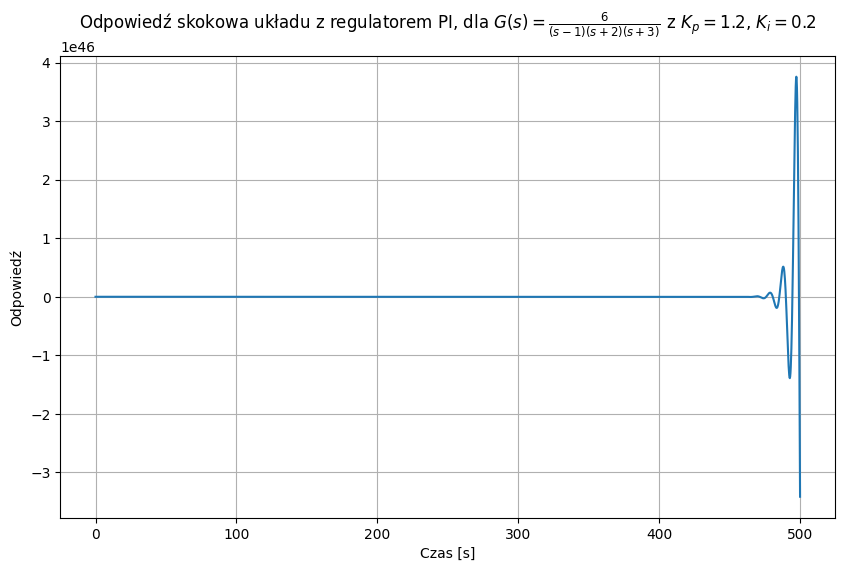

$K_p \in (1, \frac53)$, $K_i \in (0, -\frac38K_p^2 + K_p - \frac58) \implies$ **układ stabilny**

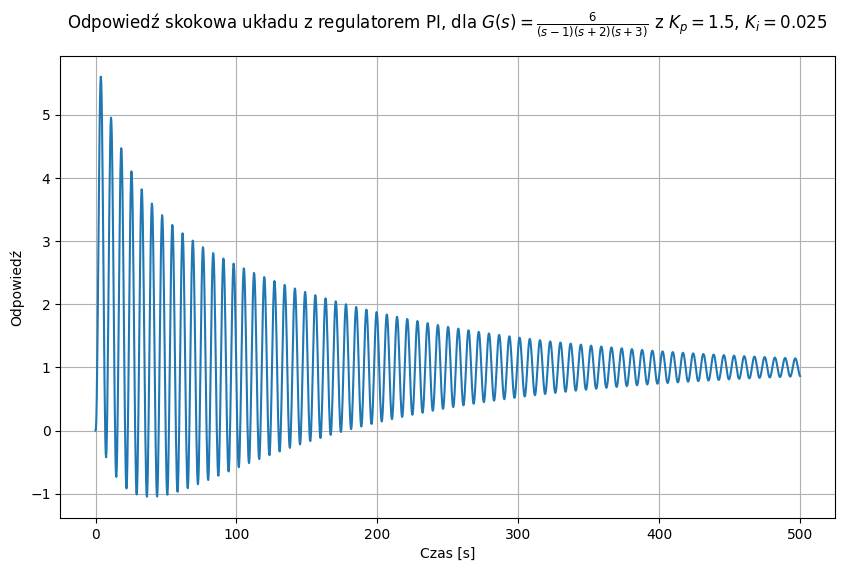

In [230]:
def PI_regulator_step_resp(G, K_p, K_i):
    L_s, M_s = sp.fraction(G)
    num_coeffs = [float(c) for c in sp.Poly(L_s, s).all_coeffs()]
    den_coeffs = [float(c) for c in sp.Poly(M_s, s).all_coeffs()]
    G_tf = ctrl.TransferFunction(num_coeffs, den_coeffs)
    
    plt.figure(figsize=(10, 6))

    # Transmitancja regulatora PI - (K_p * s + K_i)/s
    C = ctrl.TransferFunction([K_p, K_i], [1, 0])
    
    # Ujemne sprzężenie zwrotne
    T = ctrl.feedback(C * G_tf, 1)
    
    # Odpowiedź skokowa układu
    t, y = ctrl.step_response(T, T=500)
    
    plt.plot(t, y)

    plt.title(fr'Odpowiedź skokowa układu z regulatorem PI, dla $G(s) = {sp.latex(G)}$ z $K_p = {K_p}$, $K_i = {K_i}$', pad=20)
    plt.xlabel('Czas [s]')
    plt.ylabel('Odpowiedź')
    plt.grid(True)
    plt.show()


display(Markdown(fr'$K_p \not\in (1, \frac{5}{3})$, $K_i \not\in (0, -\frac{3}{8}K_p^2 + K_p - \frac{5}{8}) \implies$ **układ niestabilny**'))
PI_regulator_step_resp(G2_s, 1.0, 0)

display(Markdown(fr'$K_p \not\in (1, \frac{5}{3})$, $K_i \not\in (0, -\frac{3}{8}K_p^2 + K_p - \frac{5}{8}) \implies$ **układ niestabilny**'))
PI_regulator_step_resp(G2_s, 0.9, 1.0)

display(Markdown(fr'$K_p \in (1, \frac{5}{3})$, $K_i \not\in (0, -\frac{3}{8}K_p^2 + K_p - \frac{5}{8}) \implies$ **układ niestabilny**'))
PI_regulator_step_resp(G2_s, 1.2, 0.2)

display(Markdown(fr'$K_p \in (1, \frac{5}{3})$, $K_i \in (0, -\frac{3}{8}K_p^2 + K_p - \frac{5}{8}) \implies$ **układ stabilny**'))
PI_regulator_step_resp(G2_s, 1.5, 0.025)

### Interpretacja wyników
Wyniki symulacji są zgodne z analizą stabilności przeprowadzoną za pomocą kryterium Hurwitza:
- Dla wartości parametrów regulatora ($K_p$ dla regulatora P i $K_p$, $K_i$ dla regulatora PI) należących do wyznaczonego obszaru stabilności, układ wykazywał stabilną odpowiedź na skok jednostkowy, sygnał wyjściowy asymptotycznie dążył do wartości ustalonej z oscylacjami tłumionymi
- Dla wartości parametrów spoza wyznaczonego zakresu obserwowano rozbieżność odpowiedzi, układ nie osiągał wartości ustalonej, oscylacje rosły
- Dla wartości parametrów leżących na granicy obszaru stabilności odpowiedź układu oscylowała liniowo, co potwierdza krytyczne warunki stabilności (ostre nierówności w kryterium Hurwitza)

## Zadanie 3